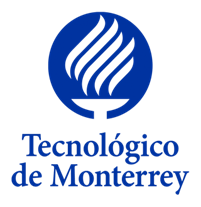

# TC 5033
## Deep Learning
## Convolutional Neural Networks
## Team Members:
- A01200230 - Armando Bringas Corpus

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
#from jupyterthemes import jtplot
#jtplot.style()

In [2]:
# Check torch version
torch.__version__

'2.1.0'

In [3]:
torch.cuda.is_available()

True

In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print(torch.cuda.get_device_capability(0))
    print(torch.cuda.get_device_properties(0))
else:
    print("No GPU available")

NVIDIA GeForce GTX 1650
(7, 5)
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4095MB, multi_processor_count=14)


### Download Cifar10 dataset

In [5]:
DATA_PATH = 'data/cifar10_data'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/cifar10_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [7]:
train_loader.batch_size

64

In [8]:
#for i, (x, y) in enumerate(train_loader):
    #print(x, y)

### Using  GPUs

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: truck


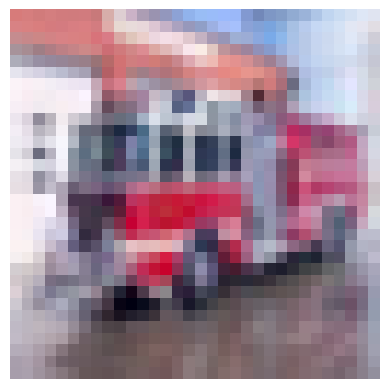

In [10]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


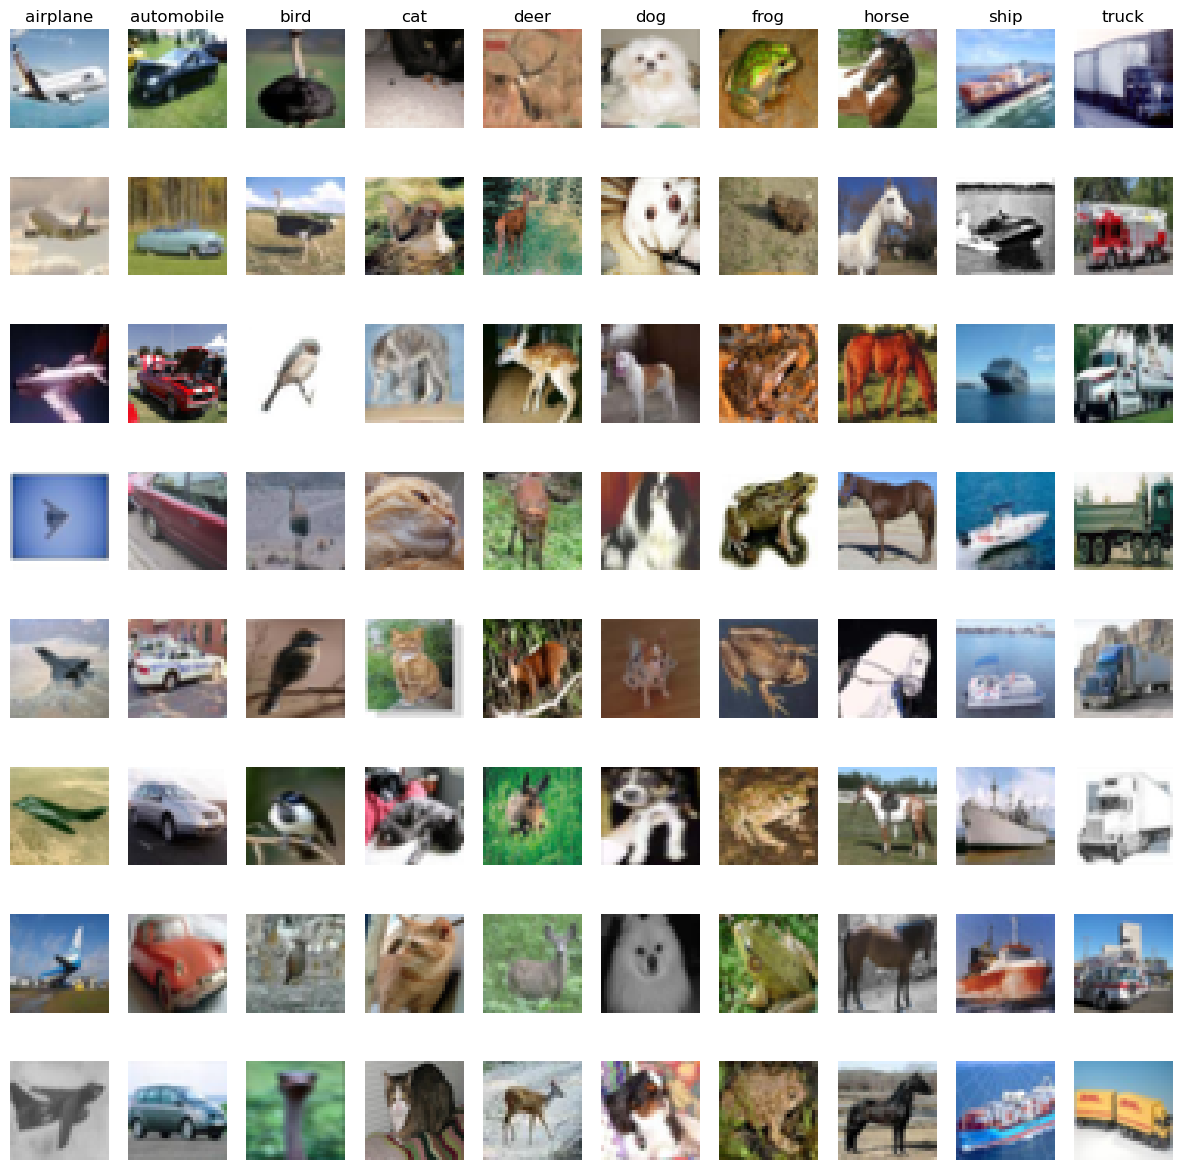

In [11]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### Calcular accuracy


In [12]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    
    # Set the model to evaluation mode and move to GPU
    model.eval()
    model.to(device)
    
    # Disable gradient calculations. Only making predictions and not updating weights, 
    # we don't need gradients. This saves memory.
    with torch.no_grad():
        # Iterate over the dataset loader
        for x_i, y_i in loader:
            # Move the input and target data to GPU
            x_i = x_i.to(device=device, dtype=torch.float32)
            y_i = y_i.to(device=device, dtype=torch.long)
            
            # Forward pass. Get output scores
            scores = model(x_i)
            
            # Get the predictions from the maximum value of the output scores
            _, pred = scores.max(dim=1)
            
             # Count how many predictions match the true labels
            num_correct += (pred == y_i).sum().item()
            num_total += pred.size(0)

    return num_correct / num_total

### Loop de entrenamiento

In [13]:
def train(model, optimiser, epochs=100):
    # move model to GPU
    model = model.to(device)
    
    # Loop over the epochs
    for epoch in range(epochs):
        # Set model to training mode
        model.train()  
        
        # Loop over training data
        for i, (x_i, y_i) in enumerate(train_loader):
            x_i = x_i.to(device=device, dtype=torch.float32)
            y_i = y_i.to(device=device, dtype=torch.long)
            
            # Forward pass. Get output scores
            scores = model(x_i)
            
            # Calculate the cost
            cost = F.cross_entropy(input= scores, target=y_i)
            
            # Zero the parameter gradients. 
            optimiser.zero_grad()
            
            # Perform a backward pass
            cost.backward()
            
            # Perform a single optimization step (parameter update)
            optimiser.step()   
        
        # Evaluate model performance after each epoch
        acc = accuracy(model, val_loader) 
        print(f'Epoch: {epoch}\t costo: {cost.item():.4f}\t accuracy: {acc:.4f}')

### Linear model

Model Hyperparameters

In [14]:
hidden1 = 256 
hidden = 256
lr = 0.001
epochs = 10

Neural Network Architecture:

Input -> Flatten -> Linear -> ReLU -> Linear -> ReLU -> Linear -> Output

This architecture is a sequence of layers configured to process input data for classification tasks. 

In [15]:
# Build neural network with sequential container
nn_model = nn.Sequential(nn.Flatten(),
                         nn.Linear(in_features=32*32*3, out_features=hidden1),
                         nn.ReLU(),
                         nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                         nn.Linear(in_features=hidden, out_features=10))

optimiser = torch.optim.Adam(nn_model.parameters(), lr=lr)

Train model and get accuracy

In [16]:
train(nn_model, optimiser, epochs)

Epoch: 0	 costo: 1.3089	 accuracy: 0.4772
Epoch: 1	 costo: 1.6215	 accuracy: 0.5046
Epoch: 2	 costo: 1.2447	 accuracy: 0.5130
Epoch: 3	 costo: 1.2868	 accuracy: 0.5198
Epoch: 4	 costo: 1.4484	 accuracy: 0.5394
Epoch: 5	 costo: 1.6341	 accuracy: 0.5258
Epoch: 6	 costo: 1.7300	 accuracy: 0.5312
Epoch: 7	 costo: 0.7726	 accuracy: 0.5346
Epoch: 8	 costo: 1.2787	 accuracy: 0.5368
Epoch: 9	 costo: 0.5760	 accuracy: 0.5282


In [17]:
#Calculate Test Partition Accuracy
accuracy(nn_model, test_loader)

0.5216

### Sequential CNN

Model Hyperparameters

In [18]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 0.0001

Input -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d -> Flatten -> Linear -> Output

This architecture represents a convolutional neural network (CNN) designed for processing image data. 

In [19]:
# Build convolutional neural network with sequential container
modelCNN_1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=channel1, 
                                   kernel_size=3, padding=1),
                          nn.ReLU(),
                          nn.Conv2d(in_channels=channel1, out_channels=channel2,
                                    kernel_size= 3, padding=1),
                          nn.ReLU(),
                          nn.MaxPool2d(2, 2),
                          nn.Flatten(),
                          nn.Linear(in_features=16*16*channel2, out_features=10)                        
                                   )
optimiser = torch.optim.Adam(modelCNN_1.parameters(), lr)

In [20]:
train(modelCNN_1, optimiser, epochs)

Epoch: 0	 costo: 1.3132	 accuracy: 0.4994
Epoch: 1	 costo: 1.4476	 accuracy: 0.5524
Epoch: 2	 costo: 1.1839	 accuracy: 0.5742
Epoch: 3	 costo: 1.2423	 accuracy: 0.5808
Epoch: 4	 costo: 1.3099	 accuracy: 0.5970
Epoch: 5	 costo: 0.6435	 accuracy: 0.6126
Epoch: 6	 costo: 1.2968	 accuracy: 0.6184
Epoch: 7	 costo: 1.1639	 accuracy: 0.6258
Epoch: 8	 costo: 0.9589	 accuracy: 0.6308
Epoch: 9	 costo: 1.3499	 accuracy: 0.6416


In [21]:
#Calculate Test Partition Accuracy
accuracy(modelCNN_1, test_loader)

0.6198

#### OOP Approach and performance improvement

In [22]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(channel1, channel2, kernel_size=3, padding=1)

In [23]:
class CNN_class(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        # # The convolutional layer takes 'in_channel' input channels and produces 'channel1' output channels.
        self.conv1 = conv_k_3(in_channel, channel1)
        # batch normalization for 'channel1'
        self.bn1 = nn.BatchNorm2d(channel1)
        # This layer takes 'channel1' input channels from the previous layer and produces 'channel2' output channels.
        self.conv2 = conv_k_3(channel1, channel2)
        # batch normalization for 'channel1'
        self.bn2 = nn.BatchNorm2d(channel2)
         # Define a max pooling layer that uses a 2x2 window
        self.max_pool = nn.MaxPool2d(2,2)
    # Forward pass
    def forward(self, x):
        x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        return self.max_pool(x)

Model Hyperparameters

In [24]:
channel1 = 32
channel2 = 64
channel3 = 128
channel4 = 256
epochs = 20
lr = 0.0001

Neural Network Architecture:

Input -> Conv2d -> BatchNorm2d -> ReLU -> Conv2d -> BatchNorm2d -> ReLU  -> Flatten -> Linear -> Output

This architecture represents a simple convolutional neural network (CNN) designed for processing image data.

In [25]:
# Build convolutional neural network with sequential container
modelCNN_2 = nn.Sequential(CNN_class(3,channel1, channel2),
                          CNN_class(channel2, channel4, channel4),
                          nn.Flatten(),
                          nn.Linear(in_features=8*8*channel4, out_features=10))

optimiser = torch.optim.Adam(modelCNN_2.parameters(), lr)

In [26]:
train(modelCNN_2, optimiser, epochs)

Epoch: 0	 costo: 1.3338	 accuracy: 0.6548
Epoch: 1	 costo: 0.9137	 accuracy: 0.6984
Epoch: 2	 costo: 0.3655	 accuracy: 0.7322
Epoch: 3	 costo: 0.2344	 accuracy: 0.7434
Epoch: 4	 costo: 0.6391	 accuracy: 0.7230
Epoch: 5	 costo: 0.2942	 accuracy: 0.7644
Epoch: 6	 costo: 0.4350	 accuracy: 0.7388
Epoch: 7	 costo: 0.4080	 accuracy: 0.7700
Epoch: 8	 costo: 0.6836	 accuracy: 0.7304
Epoch: 9	 costo: 0.2250	 accuracy: 0.7370
Epoch: 10	 costo: 0.2374	 accuracy: 0.7568
Epoch: 11	 costo: 0.0475	 accuracy: 0.7632
Epoch: 12	 costo: 0.0920	 accuracy: 0.7476
Epoch: 13	 costo: 0.0326	 accuracy: 0.7552
Epoch: 14	 costo: 0.0266	 accuracy: 0.7660
Epoch: 15	 costo: 0.0230	 accuracy: 0.7466
Epoch: 16	 costo: 0.1297	 accuracy: 0.6690
Epoch: 17	 costo: 0.1084	 accuracy: 0.7696
Epoch: 18	 costo: 0.0053	 accuracy: 0.7806
Epoch: 19	 costo: 0.0018	 accuracy: 0.7856


In [27]:
#Calculate Test Partition Accuracy
accuracy(modelCNN_2, test_loader)

0.785